In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import pandas as pd
pd.set_option('display.max.colwidth', 130)

import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm 
fm._rebuild() 
%matplotlib inline

!apt -qq -y install fonts-nanum > /dev/null
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)


import feedparser
from bs4 import BeautifulSoup as bs
import urllib
import urllib.request as req
import requests

from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize

from konlpy.tag import Kkma, Okt, Komoran
okt = Okt()
from konlpy.utils import pprint

from collections import Counter

import datetime
from datetime import timedelta

In [3]:
import re

from wordcloud import WordCloud

import nltk
nltk.download('punkt')
nltk.download('wordnet')
import string

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords


from gensim.models import Word2Vec


# 그래프에서 한글표현을 위해 폰트를 설치합니다.
# %config InlineBackend.figure_format = 'retina'

from plotnine import *
import plotnine

import warnings
warnings.filterwarnings("ignore")


remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [4]:
def next_ds(de):
    converted_de = datetime.datetime.strptime(de, '%Y.%m.%d').date()   # de를 datetime 형식으로 변환
    next_day = converted_de + timedelta(days=1)  # 1일 뒤 날짜 구함
    ds = next_day.strftime('%Y.%m.%d')
    return ds

In [5]:
day_list = []
CumNum_list = []

def get_OnlyNewsNum(keyword, p_ds, p_de):
    keyword = '+'.join(keyword.split(' '))

    last = False
    page_num = 1

    cvt_ds = datetime.datetime.strptime(p_ds, '%Y.%m.%d').date()
    cvt_de = datetime.datetime.strptime(p_de, '%Y.%m.%d').date()
    periods = (cvt_de - cvt_ds).days
    ds = p_ds

    for period in range(periods + 1):
        de = ds
        Cum_li = 0 # 페이지별 기사 수 누적 (relation list 포함됨)
        while last == False:
            url = "https://search.naver.com/search.naver?&where=news&query={0}&sm=tab_pge&sort=0&photo=0&field=0&reporter_article=&pd=3&ds={1}&de={2}&docid=&nso=so:r,p:,a:all&mynews=1&cluster_rank=238&start={3}&refresh_start=0".format(keyword,ds,de,str(page_num))
            raw = requests.get(url)
            html = raw.content
            soup = bs(html, 'html.parser')

            page = soup.find('div', {'class':'paging'})
            page_a_list = page.findAll('a')

            ul = soup.find('ul', {'class':'type01'})
            li_list = ul.findAll('li')

            if '다음페이지' in str(page_a_list[-1]):
                Cum_li += len(li_list)  # relation 기사 포함된 li_list 길이 누적시킴
                page_num += 10
                
            else:
                Cum_li += len(li_list)
                CumNum_list.append(Cum_li)
                page_num = 1
                last = True

        day_list.append(ds)
        ds = next_ds(de)
        last=False

In [6]:
get_OnlyNewsNum('춘천', '2020.01.01', '2020.04.30')

In [7]:
cum_dict = {'day' : day_list,
            'CumNum' : CumNum_list}
            
CumNews_df = pd.DataFrame(cum_dict)
CumNews_df

,day,CumNum
0,2020.01.01,400
1,2020.01.02,756
2,2020.01.03,585
3,2020.01.04,175
4,2020.01.05,493
...,...,...
116,2020.04.26,162
117,2020.04.27,1320
118,2020.04.28,753
119,2020.04.29,842


In [8]:
CumNews_df['weekend'] =0

for i in range(len(CumNews_df['day'])):
    day = CumNews_df.iloc[i,0]
    weekOrNot = datetime.datetime.strptime(day, '%Y.%m.%d').date().weekday()
    if  weekOrNot== 5 or weekOrNot == 6 :
        CumNews_df.iloc[i,2] = True
    else: 
        CumNews_df.iloc[i,2] = False
CumNews_df[3:8]

,day,CumNum,weekend
3,2020.01.04,175,True
4,2020.01.05,493,True
5,2020.01.06,759,False
6,2020.01.07,608,False
7,2020.01.08,1032,False


In [9]:
CumNews_df['dif'] = CumNews_df.weekend.astype(int).diff()
CumNews_df['group'] = ((CumNews_df.weekend.astype(int).diff() != 0)&(CumNews_df.weekend)).cumsum()
CumNews_df

,day,CumNum,weekend,dif,group
0,2020.01.01,400,False,NaN,0
1,2020.01.02,756,False,0.0,0
2,2020.01.03,585,False,0.0,0
3,2020.01.04,175,True,1.0,1
4,2020.01.05,493,True,0.0,1
...,...,...,...,...,...
116,2020.04.26,162,True,0.0,17
117,2020.04.27,1320,False,-1.0,17
118,2020.04.28,753,False,0.0,17
119,2020.04.29,842,False,0.0,17


In [10]:
range_list = CumNews_df[CumNews_df.weekend].groupby('group').day.apply(list)
range_list

group
1     [2020.01.04, 2020.01.05]
2     [2020.01.11, 2020.01.12]
3     [2020.01.18, 2020.01.19]
4     [2020.01.25, 2020.01.26]
5     [2020.02.01, 2020.02.02]
6     [2020.02.08, 2020.02.09]
7     [2020.02.15, 2020.02.16]
8     [2020.02.22, 2020.02.23]
9     [2020.02.29, 2020.03.01]
10    [2020.03.07, 2020.03.08]
11    [2020.03.14, 2020.03.15]
12    [2020.03.21, 2020.03.22]
13    [2020.03.28, 2020.03.29]
14    [2020.04.04, 2020.04.05]
15    [2020.04.11, 2020.04.12]
16    [2020.04.18, 2020.04.19]
17    [2020.04.25, 2020.04.26]
Name: day, dtype: object

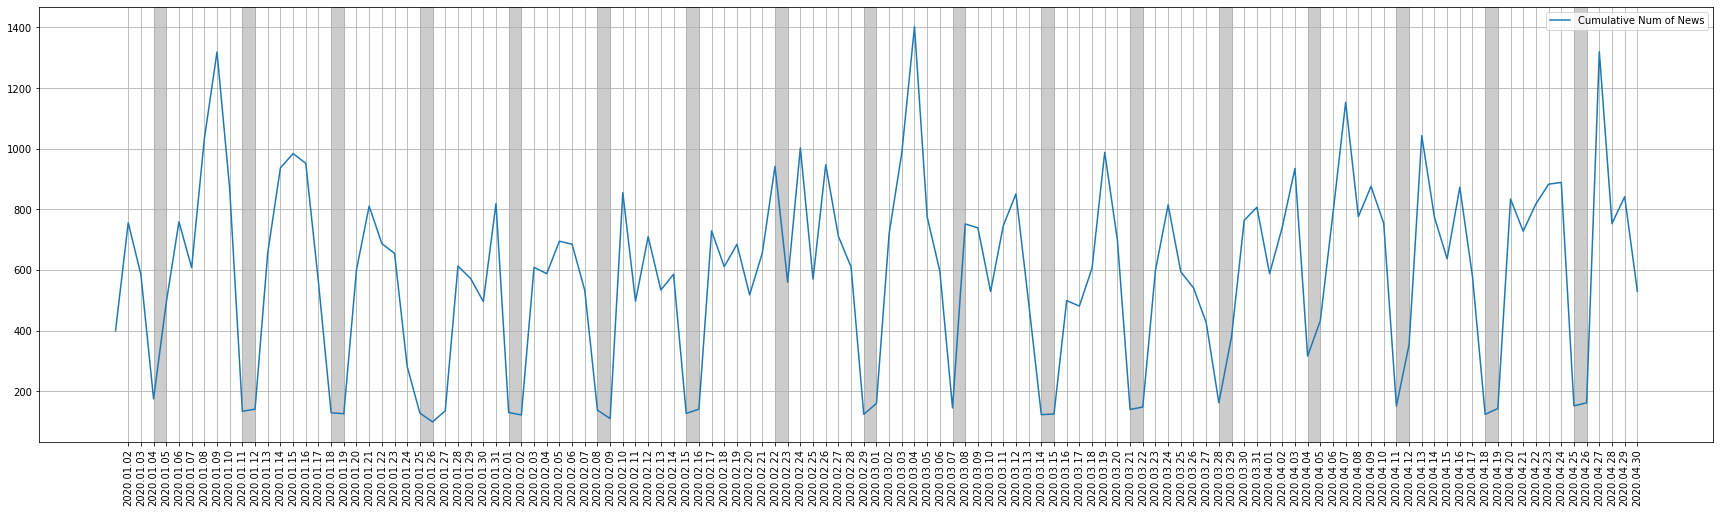

In [15]:
plt.figure(figsize=(30,8))
plt.plot(CumNews_df['day'],CumNews_df['CumNum'], label='Cumulative Num of News')
for (start, end) in range_list:
    plt.axvspan(start, end, color='gray', alpha=0.4)
plt.xticks(np.arange(1,len(CumNews_df['day'])), rotation=90)
plt.grid(True)
plt.legend()
plt.show()